### Buscar questões do dataset Chave

In [230]:
import manager_dataset as _md

questions = _md.pairs()

### Pré-processamento no texto das questões

In [231]:
import numpy as np
import random
import nltk

X = []
y = []
for question in questions:
    
    clss = question.correct_classification
    
    if clss == None:
        continue
    if clss == 'X':
        continue
    if clss == 'MANNER':
        continue
    if clss == 'OBJECT':
        continue
    if clss == 'OTHER':
        continue
    
    text = question.question
    text = text.replace('\n', '').replace('\r', '')
    text = text.replace('?', ' ? ').replace('.', ' . ').replace(',', ' , ')
    text = text.replace(':', ' : ').replace(';', ' ; ')
    text = text.replace('\'', ' \" ').replace('\"', ' \" ')
    text = text.replace(u'«', ' \" ').replace(u'»', ' \" ')
    text = text.lower()
    question.question = text
    
    text = nltk.word_tokenize(text)
    X.append(text)
    y.append(clss)

                
print 'X:',len(X),' y:',len(y)
random.seed(1)
a = zip(X, y)
random.shuffle(a)
X, y = zip(*a)
X, y = np.array(X), np.array(y)


X: 2973  y: 2973


### Modelo Word2Vec

In [3]:
import numpy as np
from gensim.models import KeyedVectors
import time

start_time = time.time()
print time.asctime()
cbow_w2v_300 = 'data/word_embedding/cbow_s300.txt'

mw2v_300 = KeyedVectors.load_word2vec_format(cbow_w2v_300, unicode_errors="ignore")
print '.'
w2v_300 = {w: vec for w, vec in zip(mw2v_300.index2word, mw2v_300.syn0)}

print("--- %s seconds ---" % (time.time() - start_time))

Tue Oct  3 12:31:52 2017
.
--- 328.721945047 seconds ---


### Modelos de representação em vetor

In [374]:
import numpy as np
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


def count_vectorizer(MIN_GRAM=1, MAX_GRAM=1, LOWER=True):
    return CountVectorizer(analyzer=lambda x: x, strip_accents=None, ngram_range=(MIN_GRAM, MAX_GRAM), 
                           token_pattern=u'(?u)\\b\\w+\\b', lowercase=LOWER)


def tfidf_vectorizer(MIN_GRAM=1, MAX_GRAM=1, LOWER=True):
    return TfidfVectorizer(analyzer=lambda x: x, strip_accents=None, ngram_range=(MIN_GRAM, MAX_GRAM), 
                           token_pattern=u'(?u)\\b\\w+\\b', lowercase=LOWER)


class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec.itervalues().next())
    
    def fit(self, X, y):
        return self

    def transform(self, X):
        ret = np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
        return ret

    
class SequenceEmbeddingVectorizer(object):
    def __init__(self, word2vec, tfidf=False):
        self.word2vec = word2vec
        self.dim = len(word2vec.itervalues().next())
        self.word2weight = None
        self.tfidf = tfidf
    
    def fit(self, X, y):
        tfidf = tfidf_vectorizer()
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
        return self

    def transform(self, X):
        ret = []
        for sentence in X:
            vector = np.array([])
            maxWords = 32
            count = 0
            for word in sentence:
                if count < maxWords:
                    if word in self.word2vec:
                        count += 1
                        if self.tfidf:
                            vector = np.concatenate([vector, self.word2vec[word] * self.word2weight[word]])
                        else:
                            vector = np.concatenate([vector, self.word2vec[word]])
            for i in range(maxWords-count):
                vector = np.concatenate([vector, np.zeros(self.dim)])
            ret.append(vector)
        ret = np.array(ret)
        return ret


class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec, LOWER=False):
        self.word2vec = word2vec
        self.word2weight = None
        self.lower = LOWER
        self.dim = len(word2vec.itervalues().next())
        
    def fit(self, X, y):
        tfidf = tfidf_vectorizer()
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

class HybridVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec.itervalues().next())
        self.bow = count_vectorizer()
        self.bow.fit(X)
    
    def fit(self, X, y):
        return self

    def transform(self, X):
        ret = []
        for sentence in X:
            w2v = np.mean([self.word2vec[w] for w in sentence if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            bow = self.bow.transform([sentence]).toarray()
            ret.append(np.concatenate([w2v, bow[0]]))
        ret = np.array(ret)
        return ret

In [318]:
cv = count_vectorizer()
a = cv.fit(X)
b = cv.transform([[u'quantas', u'pessoas', u'vivem', u'em', u'frança', u'?']]).toarray()

In [358]:
b[0]

array([0, 0, 0, ..., 0, 0, 0])

## Definir classificadores

In [375]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier


classifiers = {}  # {'classifier': (VectorizeModel, Classifier)}

#### SVM Linear

In [376]:
classifiers["SVM"] = (LinearSVC(), count_vectorizer())

In [382]:
classifiers["SVM tfidf"] = (LinearSVC(), tfidf_vectorizer())

In [381]:
classifiers["SVM W2V"] = (LinearSVC(), MeanEmbeddingVectorizer(w2v_300))

In [377]:
classifiers["SVM hybrid"] = (LinearSVC(), HybridVectorizer(w2v_300))

#### Naive Bayes

In [ ]:
classifiers["NB mult"] = (MultinomialNB(), count_vectorizer())

In [ ]:
classifiers["NB mult tfidf"] = (MultinomialNB(), tfidf_vectorizer())

In [ ]:
classifiers["NB bernoulli"] = (BernoulliNB(), count_vectorizer())

In [ ]:
classifiers["NB bern tfidf"] = (BernoulliNB(), tfidf_vectorizer())

#### ExtraTrees

In [ ]:
classifiers["ETree"] = (ExtraTreesClassifier(n_estimators=200), count_vectorizer())

In [ ]:
classifiers["ETree tfidf"] = (ExtraTreesClassifier(n_estimators=200), tfidf_vectorizer())

In [ ]:
classifiers["ETree W2V"] = (ExtraTreesClassifier(n_estimators=200), MeanEmbeddingVectorizer(w2v_300))

## Testes

In [383]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

def benchmark(model, X, y, n):
    test_size = 1 - (n / float(len(y)))
    scores = {}
    for train, test in StratifiedShuffleSplit(y, n_iter=5, test_size=test_size):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        result = model.fit(X_train, y_train).predict(X_test)
        scores['accuracy'] = accuracy_score(result, y_test)
        scores['precision'] = precision_score(result, y_test, average="macro")
        scores['recall'] = recall_score(result, y_test, average="macro")
        scores['f1'] = f1_score(result, y_test, average="macro")
        scores['confusion'] = confusion_matrix(result, y_test)
    return scores

train_sizes = [40, 80, 160, 320, 640, 1280, 2560]
table = []
for name in classifiers:
    print name,
    model = Pipeline([("vector_model", classifiers[name][1]), ("classifer", classifiers[name][0])])
    print '-',
    for n in train_sizes:
        result = benchmark(model, X, y, n)
        table.append({'model': name, 
                      'accuracy': np.mean(result['accuracy']),
                      'precision': np.mean(result['precision']),
                      'recall': np.mean(result['recall']),
                      'f1': np.mean(result['f1']),
                      #'confusion': np.mean(result['confusion'], axis=0),
                      'train_size': n})
        print n,
    print '.'


SVM hybrid - 40 80 160 320 640 1280 2560 .
SVM tfidf - 40 80 160 320 640 1280 2560 .
SVM - 40 80 160 320 640 1280 2560 .
SVM W2V - 40 80 160 320 640 1280 2560 .


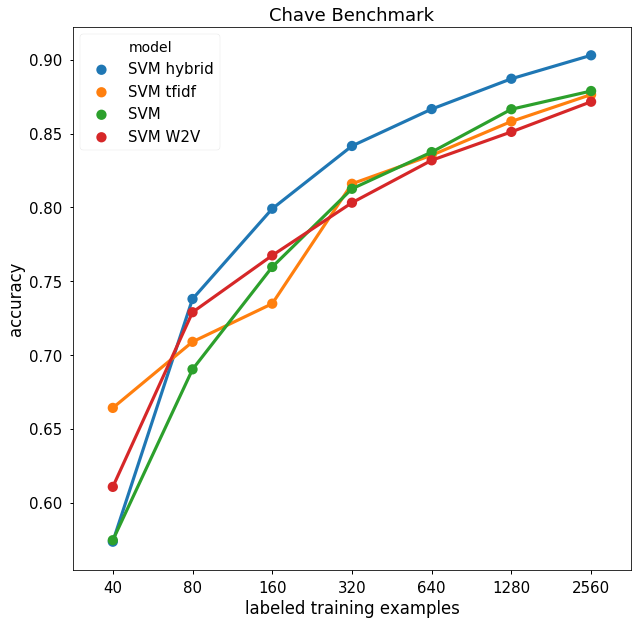

In [386]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

df = pd.DataFrame(table)
plt.figure(figsize=(10, 10))
names = ['SVM', 'SVM hybrid', 'SVM tfidf', 'SVM W2V']
fig = sns.pointplot(x='train_size', y='accuracy', hue='model', 
                    data=df[df.model.map(lambda x: x in names)])
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="accuracy")
fig.set(xlabel="labeled training examples")
fig.set(title="Chave Benchmark")
fig.set(ylabel="accuracy")